In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from transformers import TextClassificationPipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

## Import Data

In [2]:
# Import train and test data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Separate train labels and text
train_labels = train['category']
train_text = train['text']
train_labels_list = train_labels.tolist()

# Separate test labels and text
test_labels = test['category']
test_text = test['text']
test_labels_list = test_labels.tolist()

## Load in Model

In [3]:
# Load in the model
model_id = 'philschmid/BERT-Banking77'
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id)
classifier = pipeline('text-classification', tokenizer=tokenizer, model=model, return_all_scores=True)

/Users/wally/anaconda3/envs/amex/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


## Separate out the Errors

In [4]:
# Create a list of all the outputs from the classifier
outputs = []
for text in train_text:
    outputs.append(classifier(text))

In [5]:
output_table = []

# Iterate over each output and its corresponding index
for x, output in enumerate(outputs):
    data = output[0]
    
    # Find the maximum score and its corresponding label
    max_score_data = max(data, key=lambda d: d['score'])
    max_score = max_score_data['score']
    max_label = max_score_data['label']
    
    # Check if the predicted label is incorrect
    if max_label != train_labels_list[x]:
        output_table.append({
            'train_text': train_text[x],
            'true_label': train_labels_list[x],
            'predicted_label': max_label,
            'max_score': max_score,
            'correct': 0
        })
    
    # Check if the predicted label is correct
    if max_label == train_labels_list[x]:
        output_table.append({
            'train_text': train_text[x],
            'true_label': train_labels_list[x],
            'predicted_label': max_label,
            'max_score': max_score,
            'correct': 1
        })

output_table = pd.DataFrame(output_table)
output_table.to_csv('data/correct_or_not.csv', index=False)
output_table

train_text       true_label  \
0                         I am still waiting on my card?     card_arrival   
1      What can I do if my card still hasn't arrived ...     card_arrival   
2      I have been waiting over a week. Is the card s...     card_arrival   
3      Can I track my card while it is in the process...     card_arrival   
4      How do I know if I will get my card, or if it ...     card_arrival   
...                                                  ...              ...   
9998              You provide support in what countries?  country_support   
9999                  What countries are you supporting?  country_support   
10000                What countries are getting support?  country_support   
10001                     Are cards available in the EU?  country_support   
10002                   Which countries are represented?  country_support   

       predicted_label  max_score  correct  
0         card_arrival   0.980805        1  
1         card_arrival   0.979577        1  
2         card_arrival   0.978487        1  
3         card_arrival   0.978836        1  
4         card_arrival   0.966595        1  
...                ...        ...      ...  
9998   country_support   0.974441        1  
9999   country_support   0.974779        1  
10000  country_support   0.974757        1  
10001  country_support   0.973988        1  
10002  country_support   0.973620        1  

[10003 rows x 5 columns]

#### Create Dataframe with all Errors

In [6]:
# Visualize errors in data frame
pd.set_option('display.max_rows', 100)

errors_df = output_table[output_table['correct'] == 0]
errors_df

train_text  \
58    I know I'm getting a new card but would like k...   
79               maximum how many days get the courier?   
93                 WHAT IS THE SOLUTION OF THIS PROBLEM   
335               What value can I get for my currency?   
345                  What is the exchange rate for EUR?   
...                                                 ...   
9120                  how should i add money to my card   
9295  I just got a new card how do I get it to start...   
9321      I just got my card and cannot get it to work.   
9346  Why did they take more money out then I withdr...   
9573            Am I able to get this shipped to China?   

                  true_label           predicted_label  max_score  correct  
58              card_arrival    card_delivery_estimate   0.413909        0  
79              card_arrival    card_delivery_estimate   0.755571        0  
93              card_arrival          card_not_working   0.839881        0  
335            exchange_rate           exchange_charge   0.309363        0  
345            exchange_rate     fiat_currency_support   0.945048        0  
...                      ...                       ...        ...      ...  
9120   top_up_by_card_charge        topping_up_by_card   0.854572        0  
9295        activate_my_card          card_not_working   0.744899        0  
9321        activate_my_card          card_not_working   0.965759        0  
9346  cash_withdrawal_charge  declined_cash_withdrawal   0.883484        0  
9573    card_about_to_expire           transfer_timing   0.508050        0  

[166 rows x 5 columns]

In [7]:
# Print accuracy on test data
print(1-(len(errors_df)/len(train_labels_list)))

0.983404978506448


#### Create Dataframe showing only errors which the model does not predict in the top 3 labels

In [8]:
# Does the model output have the correct label in the top 3 predicted labels?
not_top3_errors = []

# Iterate over each output
for x, output in enumerate(outputs):
    data = output[0]
    
    # Sort data in descending order
    sorted_data = sorted(data, key=lambda x: x['score'], reverse=True)

    # Extract the top 3 labels and scores
    top_3_labels = [d['label'] for d in sorted_data[:3]]
    top_3_scores = [d['score'] for d in sorted_data[:3]]

    # Check if the true label is in the top 3 predicted labels
    if train_labels_list[x] not in top_3_labels:
        not_top3_errors.append({
            'train_text': train_text[x],
            'true_label': train_labels_list[x],
            'predicted_labels': top_3_labels,
            'max_scores': top_3_scores
        })

# Convert output to dataframe and output
not_top3_errors_df = pd.DataFrame(not_top3_errors)
not_top3_errors_df

train_text  \
0              maximum how many days get the courier?   
1                WHAT IS THE SOLUTION OF THIS PROBLEM   
2               What value can I get for my currency?   
3   I need some help figuring out what this strang...   
4                  Why was my account assessed a fee?   
5          Why does my transaction have an added fee?   
6           What is your shipping policies for cards?   
7                      can you express my card to me?   
8   Can I have money transferred into my account a...   
9            In what increments can I top-up my card?   
10                         HOW LONG THE CARD VALIDITY   
11    What happened to my Top-Up? It's not reflected.   
12                          Is my top up not working?   
13  Did I do something incorrectly? Where is my to...   
14  You shorted me money when I tried to make a wi...   
15  How can I get my money that I didn't get from ...   
16                    Is there an allowance on cards?   
17  i accidentally entered in my retailers informa...   
18                               My transfer isn't in   
19  |I moved out of my old house two weeks ago and...   
20  I put some money in my account the other day b...   
21                   What is the status of my top up?   
22        I have a charge for something I didn't buy.   
23                       I can't do the verification.   
24           app malfunctioning, does not know its me   
25                           What cards do you offer?   
26         I cannot tell what my top up currently is.   
27        my top up isnt there yet where do i find it   
28                         I can't access my account.   
29              When will the transaction go through?   
30                      Why didn't my payment process   
31                               My cards were stolen   
32      How do I reverse a transaction on my account?   
33                  Why would you cancel my transfer?   
34  May monthly payment to Apple has been declined...   
35  Transfers can take up to one day to process be...   
36  It's been a couple days how much longer do I h...   
37     When can I expect the transfer to be complete?   
38  Its been 3 days, How long will my transfer tak...   
39  Are there restrictions to transfers to certain...   
40  I have tried to submit a transfer a couple of ...   
41  My money is all gone. What ways are okay to ad...   
42                           How do i verify my card?   
43                   What can I do to verify my card?   
44                          Is a new debit card free?   
45                         Is a physical charge extra   
46   An overseas cash transfer did not work correctly   
47             Whats wrong with my currency exchange?   
48  I did a bank transfer to top up, but the money...   
49  My credit card transaction was declined for a ...   
50  Transferred to account is not successful, help...   
51                     When will my transfer process?   
52       should i add money via bank transfer instead   
53                  how should i add money to my card   
54      I just got my card and cannot get it to work.   
55            Am I able to get this shipped to China?   

                                 true_label  \
0                              card_arrival   
1                              card_arrival   
2                             exchange_rate   
3                 extra_charge_on_statement   
4                 extra_charge_on_statement   
5                 extra_charge_on_statement   
6                    card_delivery_estimate   
7                    card_delivery_estimate   
8                          automatic_top_up   
9                          automatic_top_up   
10                         card_not_working   
11                           pending_top_up   
12                           pending_top_up   
13                           pending_top_up   
14            wrong_amount_of_cash_received   
15            wrong_amount_of_cash_receiv

In [9]:
# Print accuracy on test data
print(1-(len(not_top3_errors_df)/len(test_labels_list)))

0.974025974025974


## Create Graph Showing Threshold Max Score Confidence vs. Error Rate

In [10]:
# Make predictions on test data
predictions_list = []

for output in outputs:
    data = output[0]

    # Find the maximum score and its corresponding label
    max_score_data = max(data, key=lambda d: d['score'])
    predictions_list.append(max_score_data)

test_predictions = []
for output in predictions_list:
    test_predictions.append(output)


In [11]:
# Function to calculate precision, recall, and F1 score based on threshold
def calculate_metrics(predictions, true_labels, threshold):
    predicted_labels = []
    for pred in predictions:
        if pred['score'] < threshold:
            predicted_labels.append('incorrect')
        else:
            predicted_labels.append(pred['label'])

    precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=1)
    recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=1)
    f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=1)
    
    return precision, recall, f1

# Define thresholds to test
thresholds = np.linspace(0,0.95,150)

# # Calculate precision, recall, and F1 score for each threshold
# for threshold in thresholds:
#     precision, recall, f1 = calculate_metrics(test_predictions, test_labels_list, threshold)
#     print(f"At threshold {threshold}: Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

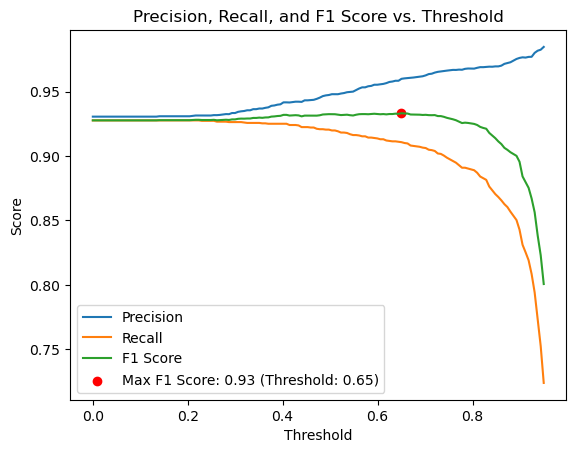

In [12]:
# Lists to store precision, recall, and F1 score for each threshold
precisions = []
recalls = []
f1_scores = []

# Calculate precision, recall, and F1 score for each threshold
for threshold in thresholds:
    precision, recall, f1 = calculate_metrics(test_predictions, test_labels_list, threshold)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Find the threshold corresponding to the maximum F1 score
max_f1_index = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_index]
max_f1_score = f1_scores[max_f1_index]

# Plot precision
plt.plot(thresholds, precisions, label='Precision')

# Plot recall
plt.plot(thresholds, recalls, label='Recall')

# Plot F1 score
plt.plot(thresholds, f1_scores, label='F1 Score')

# Highlight the maximum F1 score
plt.scatter(max_f1_threshold, max_f1_score, color='red', label=f'Max F1 Score: {max_f1_score:.2f} (Threshold: {max_f1_threshold:.2f})')

# Add labels and title
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Threshold')
plt.legend()

# Show the plot
plt.show()

## Train A Decision Tree Model On the Results of the BERT Model to Predict if an Error will Occur

In [13]:
text = output_table['test_text']
labels = output_table['correct']

# Create a Vectorizer
vectorizer = TfidfVectorizer(use_idf=True)
X = vectorizer.fit_transform(text)

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42)

In [14]:
# Train random forest  classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [15]:
# Predict on test set
rf_test_predictions = rf_clf.predict(X_test)
print(classification_report(y_test, rf_test_predictions))

              precision    recall  f1-score   support

           0       0.50      0.03      0.05        70
           1       0.93      1.00      0.96       854

    accuracy                           0.92       924
   macro avg       0.71      0.51      0.51       924
weighted avg       0.89      0.92      0.89       924



In [16]:
#, zero_division=1

## Extracting Logits and Softmax Probabilities

In [17]:
# Output of raw logits (from Mariya's email/stackoverflow code)
class logitFinder(TextClassificationPipeline):
    def postprocess(self, model_outputs):
        best_class = model_outputs["logits"]
        return best_class

classifier = pipeline('text-classification', model=model_id, tokenizer=tokenizer)
type(classifier)

pipe = logitFinder(model = model, tokenizer = tokenizer)
logit_outputs = pipe(test_text.tolist(), batch_size=2, truncation="only_first")

In [18]:
# Convert it into a NumPy array
logits_array = np.array([np.array(logit) for logit in logit_outputs])

# Flatten the logits array to ensure consistent shape
logits_flat = logits_array.reshape(logits_array.shape[0], -1)

# Apply softmax function to logits
softmax_probs = np.exp(logits_flat) / np.sum(np.exp(logits_flat), axis=1, keepdims=True)

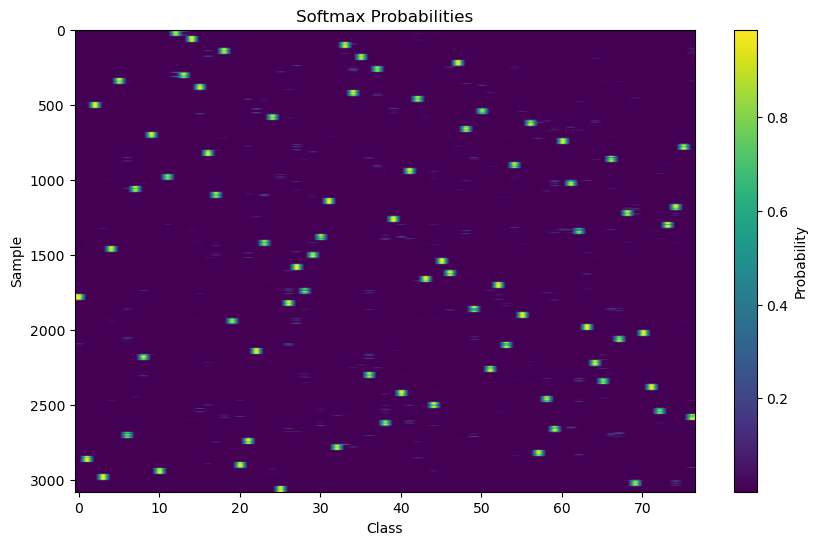

In [19]:
# Visualize Softmaxes
# Apply softmax function to logits
softmax_probs = np.exp(logits_flat) / np.sum(np.exp(logits_flat), axis=1, keepdims=True)

# Define a function to visualize softmax probabilities
def visualize_softmax_probs(softmax_probs):
    # Plotting heatmap
    plt.figure(figsize=(10, 6))
    plt.imshow(softmax_probs, cmap='viridis', aspect='auto')
    plt.colorbar(label='Probability')
    plt.xlabel('Class')
    plt.ylabel('Sample')
    plt.title('Softmax Probabilities')
    plt.show()

# Visualize softmax probabilities
visualize_softmax_probs(softmax_probs)

## Implementation of Softmax Prediction Probability from Hendrycks and Gimpel

In [20]:
# Create dataframe of correct predictions

# Elements to exclude
error_text = errors_df

# Create a boolean mask to filter out elements
mask = np.isin(test_text, error_text, invert=True)

# Use the mask to filter elements
correct_predictions = test_text[mask]

#### Find Softmaxes of Correct Predictions

In [21]:
# Get logit outputs
correct_logits = pipe(correct_predictions.tolist(), batch_size=2, truncation="only_first") 

# Convert it into a NumPy array
correct_logits_array = np.array([np.array(logit) for logit in correct_logits])

# Flatten the logits array to ensure consistent shape
correct_logits_flat = correct_logits_array.reshape(correct_logits_array.shape[0], -1)

# Apply softmax function to logits
correct_softmax_probs = np.exp(correct_logits_flat) / np.sum(np.exp(correct_logits_flat), axis=1, keepdims=True)

#### Find Softmaxes of Erroneous Predictions

In [22]:
# Get logit outputs
erroneous_logits = pipe(error_text['test_text'].tolist(), batch_size=2, truncation="only_first") 

# Convert it into a NumPy array
erroneous_logits_array = np.array([np.array(logit) for logit in erroneous_logits])

# Flatten the logits array to ensure consistent shape
erroneous_logits_flat = erroneous_logits_array.reshape(erroneous_logits_array.shape[0], -1)

# Apply softmax function to logits
erroneous_softmax_probs = np.exp(erroneous_logits_flat) / np.sum(np.exp(erroneous_logits_flat), axis=1, keepdims=True)

#### Comparing Softmaxes of Correct and Erroneous

In [24]:
# Find mean of maximum values for each correct softmax calculation
comb_correct_max_vals = []
for label in correct_softmax_probs:
    max_val = max(label)
    comb_correct_max_vals.append(max_val)

print(np.mean(comb_correct_max_vals))


0.9472402


In [ ]:
# Find mean of maximum values for each erroneous softmax calculation
comb_erroneous_max_vals = []
for label in erroneous_softmax_probs:
    max_val = max(label)
    comb_erroneous_max_vals.append(max_val)

print(np.mean(comb_erroneous_max_vals))

0.6872993


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
import scipy.sparse

# Dataset loading and preprocessing 
X = X 
y = labels
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X)

# Convert CSR matrix to TensorFlow sparse tensor
sparse_tensor = tf.sparse.SparseTensor(
    indices=np.array(X_scaled.nonzero()).T,
    values=X_scaled.data,
    dense_shape=X_scaled.shape
)

sorted_indices = tf.sparse.reorder(sparse_tensor)

# Convert SparseTensor to dense tensor
dense_tensor = tf.sparse.to_dense(sorted_indices)

# Convert dense tensor to numpy array
numpy_array = tf.convert_to_tensor(dense_tensor).numpy()

# Convert numpy array to CSR matrix
csr_matrix = scipy.sparse.csr_matrix(numpy_array)

# Convert labels to categorical (if they are not already)
y_categorical = to_categorical(y)

# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(csr_matrix, y_categorical, test_size=0.2)

# 2. Model Architecture
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))  # Adjust the input shape
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))  # Assuming a binary classification (mislabeled vs not)


# 3. Training
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=12, batch_size=64, validation_data=(X_val, y_val))

# 4. Evaluation
performance = model.evaluate(X_val, y_val)
print(f'Validation Loss: {performance[0]}, Validation Accuracy: {performance[1]}')

Epoch 1/12
39/39 [==============================] - 0s 2ms/step - loss: 0.4454 - accuracy: 0.8316 - val_loss: 0.4203 - val_accuracy: 0.9058
Epoch 2/12
39/39 [==============================] - 0s 986us/step - loss: 0.1820 - accuracy: 0.9403 - val_loss: 0.3807 - val_accuracy: 0.9075
Epoch 3/12
39/39 [==============================] - 0s 1ms/step - loss: 0.1085 - accuracy: 0.9570 - val_loss: 0.3919 - val_accuracy: 0.9075
Epoch 4/12
39/39 [==============================] - 0s 1ms/step - loss: 0.0740 - accuracy: 0.9724 - val_loss: 0.4277 - val_accuracy: 0.9091
Epoch 5/12
39/39 [==============================] - 0s 1ms/step - loss: 0.0522 - accuracy: 0.9813 - val_loss: 0.4553 - val_accuracy: 0.9091
Epoch 6/12
39/39 [==============================] - 0s 2ms/step - loss: 0.0394 - accuracy: 0.9874 - val_loss: 0.4932 - val_accuracy: 0.9058
Epoch 7/12
39/39 [==============================] - 0s 1ms/step - loss: 0.0298 - accuracy: 0.9911 - val_loss: 0.5255 - val_accuracy: 0.9075
Epoch 8/12
39/39 [